# Prototype Developing for Linear Bandits with Side Observations
Suppose a graph over users and a universal set of articles  
https://docs.google.com/document/d/1Vb26PCYE0MO8qqXkUDUrOVgNLtOpQM5BKhQiqg05gtM/edit

In [15]:
import random
import numpy as np
import matplotlib.pyplot as plt
import copy
import itertools
import scipy.optimize as opt

unitTestOn = True

class LinearEnvironment:
    """
    finite set of articles
    """
    def __init__(self, dim=10, numOfUsers=10, numOfArticles=10, er=0.5):
        self.dim = dim
        self.numOfUsers = numOfUsers
        self.numOfArticles = numOfArticles
        self.neighbors = [[] for i in range(numOfUsers)]
        for i in range(numOfUsers):
            for j in range(numOfUsers):
                if i==j or random.random() <= er:
                    self.neighbors[i].append(j)
        self.theta = []
        for i in range(numOfUsers):
            self.theta.append(np.array([random.random() for k in range(dim)]))
        self.context = []
        for j in range(numOfArticles):
            self.context.append(np.array([random.random() for k in range(dim)]))
            
    def reveal(self):
        return self.neighbors, self.context
    
    def feedback(self, user, article):
        return np.inner(self.theta[user], self.context[article]) + random.gauss(0, 1)
    
    def optimal_value(self, T):
        optValuePerStep = 0
        for user in range(self.numOfUsers):
            optValuePerStep += max([np.inner(self.theta[user], self.context[article]) for article in range(self.numOfArticles)])
        optimalValue = np.ones(T) * optValuePerStep
        return optimalValue

In [2]:
if unitTestOn:
    myEnvironment = LinearEnvironment(er=0.3)
    neighbors, context = myEnvironment.reveal()
    print(neighbors)
    print(context[0].shape)
    for i in range(10):
        print(myEnvironment.feedback(0, 0))
    optimalValue = myEnvironment.optimal_value(10)
    print(optimalValue)

[[0, 2, 5, 9], [0, 1, 5, 7], [2, 3, 5, 8], [0, 2, 3, 6, 7, 8], [4, 6, 7], [0, 5, 6, 9], [5, 6, 8], [6, 7], [1, 5, 8], [2, 9]]
(10,)
4.350470090791317
2.513528741635384
2.5502462900627174
3.2775728137203353
2.634413621355443
4.694136794143082
3.7108629724161917
3.2273715637887617
4.796369701389509
4.2330243911304954
[36.4075374 36.4075374 36.4075374 36.4075374 36.4075374 36.4075374
 36.4075374 36.4075374 36.4075374 36.4075374]


In [192]:
def testbed(bandit):
    T = 10000
    dim=2
    numOfUsers=2
    numOfArticles=10
    er=0.3
    myEnvironment = LinearEnvironment(dim=dim, numOfUsers=numOfUsers, numOfArticles=numOfArticles, er=er)
    neighbors, context = myEnvironment.reveal()
    optPayoff = myEnvironment.optimal_value(T)
    # run experiments
    repeat = 10
    avg_regret = [0 for t in range(T)]
    for run in range(repeat):
        if run%10 == 0: 
            print('running round '+str(run)+'\n')
        payoff = bandit(myEnvironment, T, dim, numOfUsers, numOfArticles, neighbors, context)
        for t in range(T):
            avg_regret[t] += (optPayoff[t] - payoff[t])/repeat
    cum_regret = [avg_regret[0]]
    for t in range(1,T):
        cum_regret.append(cum_regret[-1]+avg_regret[t])
    plt.semilogx(cum_regret)
    plt.show()


## LinUCB proposed by Li et. al.
https://dl.acm.org/doi/pdf/10.1145/1772690.1772758

In [4]:
def LinUCB(myEnvironment, T, dim, numOfUsers, numOfArticles, neighbors, context):
    alpha = 1 + np.sqrt(np.log(2*T)/2)
    matrixA = [np.identity(dim) for user in range(numOfUsers)]
    vectorB = [np.zeros((dim,1)) for user in range(numOfUsers)]
    theta = [np.zeros((dim,1)) for user in range(numOfUsers)]
    payoff = []
    for t in range(T):
        tmpPayoff = 0
        for user in range(numOfUsers):
            matrixA_inv = np.linalg.inv(matrixA[user])
            theta[user] = np.dot(matrixA_inv,vectorB[user])
            ucb = []
            for x in context:
                p = np.dot(theta[user].transpose(),x.reshape(dim,1))  
                ucb.append(p+alpha*np.sqrt(np.dot(np.dot(x.reshape(1,dim),matrixA_inv),x.reshape(dim,1))))
            action = np.argmax(ucb)
            rew = myEnvironment.feedback(user, action)
            matrixA[user] += np.dot(context[action].reshape(dim,1),context[action].reshape(1,dim))
            vectorB[user] += rew*context[action].reshape(dim,1)
            tmpPayoff += rew
        payoff.append(tmpPayoff)
    return payoff

running round 0

running round 10

running round 20

running round 30

running round 40

running round 50

running round 60

running round 70

running round 80

running round 90



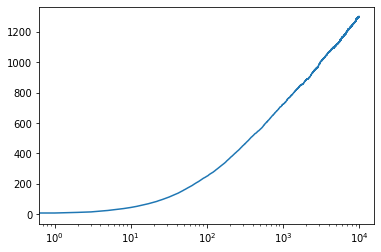

In [5]:
testbed(LinUCB)

In [47]:
def LinUCB_N(myEnvironment, T, dim, numOfUsers, numOfArticles, neighbors, context):
    alpha = 1 + np.sqrt(np.log(2*T)/2)
    matrixA = [np.identity(dim) for user in range(numOfUsers)]
    vectorB = [np.zeros((dim,1)) for user in range(numOfUsers)]
    theta = [np.zeros((dim,1)) for user in range(numOfUsers)]
    payoff = []
    action = [0 for user in range(numOfUsers)]
    for t in range(T):
        tmpPayoff = 0
        for user in range(numOfUsers):
            matrixA_inv = np.linalg.inv(matrixA[user])
            theta[user] = np.dot(matrixA_inv,vectorB[user])
            ucb = []
            for x in context:
                p = np.dot(theta[user].transpose(),x.reshape(dim,1))  
                ucb.append(p+alpha*np.sqrt(np.dot(np.dot(x.reshape(1,dim),matrixA_inv),x.reshape(dim,1))))
            action[user] = np.argmax(ucb)
        for user in range(numOfUsers):
            article = action[user]
            for neigh in neighbors[user]:
                rew = myEnvironment.feedback(neigh, article)
                if neigh == user:
                    tmpPayoff += rew
                matrixA[neigh] += np.dot(context[article].reshape(dim,1),context[article].reshape(1,dim))
                vectorB[neigh] += rew*context[article].reshape(dim,1)
        payoff.append(tmpPayoff)
    return payoff

In [48]:
testbed(LinUCB_N)

running round 0



KeyboardInterrupt: 

### Barycentric Spanner approximate solver
http://www.cs.cornell.edu/courses/cs683/2007sp/papers/OLSP.pdf  
https://www.stat.berkeley.edu/~bartlett/courses/2014fall-cs294stat260/lectures/linear-bandits-2-notes.pdf

In [17]:
def barycentric_spanner(S, delta):
    K = len(S)
    if K == 0:
        return
    d = len(S[0])
    if K < d:
        return
    res = random.sample(S, d)
    print("barycentric_spanner: Looking for initial basis\n")
    while abs(np.linalg.det(res)) <= 0:
        res = random.sample(S, d)
    print("barycentric_spanner: Found initial basis\n")
    for i in range(d):
        det_value = []
        res_copy = copy.copy(res)
        for j in range(K):
            res_copy[i] = S[j]
            det_value.append(abs(np.linalg.det(res_copy)))
        i_max = np.argmax(det_value)
        res[i] = S[i_max]
    print("barycentric_spanner: Maximized each dimension\n")
    C = 1 + delta
    Terminate = False
    while not Terminate:
        Terminate = True
        tmp = abs(np.linalg.det(res))
        for i, j in itertools.product(range(d), range(K)):
            res_copy = copy.copy(res)
            res_copy[i] = S[j]
            new_tmp = abs(np.linalg.det(res_copy))
            if new_tmp > C * tmp:
                res[i] = S[j]
                tmp = new_tmp
                Terminate = False
    return res

In [101]:
def barycentric_spanner_index(S, delta):
    K = len(S)
    if K == 0:
        return
    d = len(S[0])
    if K < d:
        return
    res = random.sample(range(K), d)
    # print("barycentric_spanner: Looking for initial basis\n")
    while abs(np.linalg.det([S[i] for i in res])) <= 0:
        res = random.sample(range(K), d)
    # print("barycentric_spanner: Found initial basis\n")
    for i in range(d):
        det_value = []
        res_copy = copy.copy(res)
        for j in range(K):
            res_copy[i] = j
            det_value.append(abs(np.linalg.det([S[k] for k in res_copy])))
        i_max = np.argmax(det_value)
        res[i] = i_max
    # print("barycentric_spanner: Maximized each dimension\n")
    C = 1 + delta
    Terminate = False
    while not Terminate:
        Terminate = True
        tmp = abs(np.linalg.det([S[i] for i in res]))
        for i, j in itertools.product(range(d), range(K)):
            res_copy = copy.copy(res)
            res_copy[i] = j
            new_tmp = abs(np.linalg.det([S[k] for k in res_copy]))
            if new_tmp > C * tmp:
                res[i] = j
                tmp = new_tmp
                Terminate = False
    return res

In [156]:
def f_n_delta(n, delta, dim):
    c = 1
    return 2*(1+1/np.log(n))*np.log(1/delta) + c*dim*np.log(dim*np.log(n))

def f_n(n, dim):
    return f_n_delta(n, 1/n, dim)

def g_n(n, dim):
    return f_n_delta(n, 1/np.log(n), dim)

def oracle_linear_approx(gap, T, dim, context):
    fn = f_n(T, dim)
    k = len(context)
    c = np.array(gap)
    Aeq = np.ones((1,k))
    beq = np.array([T])
    gap_filter_index = [(i,g) for i,g in enumerate(gap) if g>0]
    gap_min = np.min(gap_filter_index,axis=0)[1]
    gap_max = np.max(gap_filter_index,axis=0)[1]
    Aub =np.array([1 if g>0 else 0 for g in gap]).reshape(1,k)
    bub =np.array([2*dim**3 * fn*gap_max/(gap_min**3)])
    #TODO: the remaining constraints are not linear since xxT is not invertible
    return opt.linprog(c, A_ub=Aub, b_ub=bub, A_eq=Aeq, b_eq=beq).x
    
def oracle_obj(x, gap):
    return np.dot(x.transpose(),np.array(gap))

def oracle_constr(x, gap, T, dim, context):
    fn = f_n(T, dim)
    k = len(context)
    constr = []
    # constr.append(T - np.sum(x))
    gap_filter_index = [(i,g) for i,g in enumerate(gap) if g>0]
    gap_min = np.min(gap_filter_index,axis=0)[1]
    gap_max = np.max(gap_filter_index,axis=0)[1]
    constr.append(2*dim**3 * fn*gap_max/(gap_min**3) - np.sum([x[i] for i,g in gap_filter_index]))
    H = np.zeros((dim,dim))
    for i in range(k):
        H += x[i] * np.dot(context[i].reshape(dim,1),context[i].reshape(1,dim))
    H_inv = np.linalg.pinv(H)
    for i,g in gap_filter_index:
        constr.append(g*g/fn - np.dot(np.dot(context[i].reshape(1,dim),H_inv),context[i].reshape(dim,1))[0][0])
    return np.array(constr)
    
def oracle(gap, T, dim, context):
    k = len(context)
    x_0 = np.ones(k)*T/k
    bounds = [(0,None) for i in range(k)]
    cons = ({'type': 'ineq', 'fun': oracle_constr, 'args': (gap, T, dim, context)})
    res = opt.minimize(oracle_obj,x_0,args=(gap),bounds=bounds, constraints=cons)#, method='SLSQP')
    # check the sum = T with print if violating
    if np.sum(res.x) < T:
        opt_act = np.argmin(gap)
        adj_res = [res.x[i] for i in range(k)]
        adj_res[opt_act] += T - np.sum(res.x)
        # print("oracle output sum < T\n")
        return np.array(adj_res)
    else:
        return res.x/np.sum(res.x)*T
    
def Lattimore(myEnvironment, T, dim, numOfUsers, numOfArticles, neighbors, context):
    barycentric_tolerance = 0.1
    spanner_B = barycentric_spanner_index(context, barycentric_tolerance)
    alpha = 1 + np.sqrt(np.log(2*T)/2)
    matrixA = [np.identity(dim) for user in range(numOfUsers)]
    vectorB = [np.zeros((dim,1)) for user in range(numOfUsers)]
    theta = [np.zeros((dim,1)) for user in range(numOfUsers)]
    success = [True for user in range(numOfUsers)]
    count = [np.zeros((numOfArticles,1)) for user in range(numOfUsers)]
    payoff = []
    bounds = [None for user in range(numOfUsers)]
    for t in range(T):
        tmpPayoff = 0
        for user in range(numOfUsers):
            mu_prev = [np.inner(theta[user].reshape(dim,),x) for x in context]
            matrixA_inv = np.linalg.inv(matrixA[user])
            theta[user] = np.dot(matrixA_inv,vectorB[user])
            mu = [np.inner(theta[user].reshape(dim,),x) for x in context]
            confidence = [np.sqrt(np.dot(np.dot(x.reshape(1,dim),matrixA_inv),x.reshape(dim,1)))[0][0] for x in context]
            if t < dim*np.ceil(np.sqrt(np.log(T))):
                action = spanner_B[t%dim]
            elif success[user]:
                epsilon = np.max(confidence) * np.sqrt(g_n(T,dim))
                largest = np.max(mu)
                gap = [largest - mean for mean in mu]
                if np.max([abs(mean - mean_prev) for mean, mean_prev in zip(mu,mu_prev)]) > 2 * epsilon:
                    success[user] = False
                else:
                    # play action according to the optimizer
                    if t == dim*np.ceil(np.sqrt(np.log(T))):
                        bounds[user] = oracle(gap, T, dim, context)
                        # print(bounds[user])
                    action = np.random.choice([i for i in range(numOfArticles) if count[user][i] <= np.ceil(bounds[user][i])])
            if not success[user]:
                action = np.argmax(np.array(mu) + np.array(confidence) * alpha)
            count[user][action] += 1
            rew = myEnvironment.feedback(user, action)
            matrixA[user] += np.dot(context[action].reshape(dim,1),context[action].reshape(1,dim))
            vectorB[user] += rew*context[action].reshape(dim,1)
            tmpPayoff += rew
        payoff.append(tmpPayoff)
    # print(count)
    return payoff

running round 0



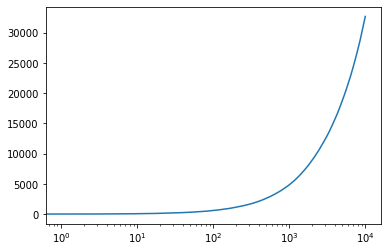

In [157]:
testbed(Lattimore)

In [159]:
def Lattimore_N(myEnvironment, T, dim, numOfUsers, numOfArticles, neighbors, context):
    barycentric_tolerance = 0.1
    spanner_B = barycentric_spanner_index(context, barycentric_tolerance)
    alpha = 1 + np.sqrt(np.log(2*T)/2)
    matrixA = [np.identity(dim) for user in range(numOfUsers)]
    vectorB = [np.zeros((dim,1)) for user in range(numOfUsers)]
    theta = [np.zeros((dim,1)) for user in range(numOfUsers)]
    success = [True for user in range(numOfUsers)]
    count = [np.zeros((numOfArticles,1)) for user in range(numOfUsers)]
    payoff = []
    bounds = [None for user in range(numOfUsers)]
    action = [0 for user in range(numOfUsers)]
    for t in range(T):
        tmpPayoff = 0
        for user in range(numOfUsers):
            mu_prev = [np.inner(theta[user].reshape(dim,),x) for x in context]
            matrixA_inv = np.linalg.inv(matrixA[user])
            theta[user] = np.dot(matrixA_inv,vectorB[user])
            mu = [np.inner(theta[user].reshape(dim,),x) for x in context]
            confidence = [np.sqrt(np.dot(np.dot(x.reshape(1,dim),matrixA_inv),x.reshape(dim,1)))[0][0] for x in context]
            if t < dim*np.ceil(np.sqrt(np.log(T))):
                action[user] = spanner_B[t%dim]
            elif success[user]:
                epsilon = np.max(confidence) * np.sqrt(g_n(T,dim))
                largest = np.max(mu)
                gap = [largest - mean for mean in mu]
                if np.max([abs(mean - mean_prev) for mean, mean_prev in zip(mu,mu_prev)]) > 2 * epsilon:
                    success[user] = False
                else:
                    # play action according to the optimizer
                    if t == dim*np.ceil(np.sqrt(np.log(T))):
                        bounds[user] = oracle(gap, T, dim, context)
                        # print(bounds[user])
                    action[user] = np.random.choice([i for i in range(numOfArticles) if count[user][i] <= np.ceil(bounds[user][i])])
            if not success[user]:
                action[user] = np.argmax(np.array(mu) + np.array(confidence) * alpha)
        for user in range(numOfUsers):
            article = action[user]
            for neigh in neighbors[user]:
                rew = myEnvironment.feedback(neigh, article)
                if neigh == user:
                    tmpPayoff += rew
                    count[user][article] += 1
                matrixA[neigh] += np.dot(context[article].reshape(dim,1),context[article].reshape(1,dim))
                vectorB[neigh] += rew*context[article].reshape(dim,1)
        payoff.append(tmpPayoff)
    # print(count)
    return payoff

running round 0



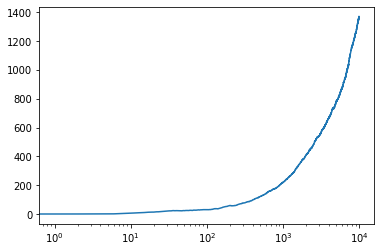

In [200]:
testbed(Lattimore_N)

In [198]:
def oracle_obj_LP(x, gap):
    return np.dot(x.transpose(),np.array(gap).flatten())

def oracle_constr_LP(x, gap, T, dim, context, neighbors):
    fn = f_n(T, dim)
    k = len(context)
    numOfUsers = len(gap)
    constr = []
    plays = x.reshape(numOfUsers, k)
    H = [np.zeros((dim,dim)) for user in range(numOfUsers)]
    for user in range(numOfUsers):
        for article in range(k):
            for neigh in neighbors[user]:
                H[neigh] += plays[user][article] * np.dot(context[article].reshape(dim,1),context[article].reshape(1,dim))
    H_inv = [np.linalg.pinv(H[user]) for user in range(numOfUsers)]
    for user in range(numOfUsers):
        for article in range(k):
            if gap[user][article] > 0:
                constr.append(gap[user][article]*gap[user][article]/fn - np.dot(np.dot(context[article].reshape(1,dim),H_inv[user]),context[article].reshape(dim,1))[0][0])
    return np.array(constr)
    
def oracle_LP(gap, T, dim, context, neighbors):
    k = len(context)
    numOfUsers = len(gap)
    x_0 = np.ones(k*numOfUsers)*T/k
    bounds = [(0,None) for i in range(k*numOfUsers)]
    cons = ({'type': 'ineq', 'fun': oracle_constr_LP, 'args': (gap, T, dim, context, neighbors)})
    res = opt.minimize(oracle_obj_LP,x_0,args=(gap),bounds=bounds, constraints=cons)#, method='SLSQP')
    bounds = res.x.reshape(numOfUsers, k)
    for user in range(numOfUsers):
        if np.sum(bounds[user]) < T:
            adj = T - np.sum(bounds[user])
            opt_act = np.argmin(gap[user])
            bounds[user][opt_act] += adj
        else:
            bounds[user] = bounds[user]/np.sum(bounds[user]) * T
    return bounds

def Optimal_LP(myEnvironment, T, dim, numOfUsers, numOfArticles, neighbors, context):
    barycentric_tolerance = 0.1
    spanner_B = barycentric_spanner_index(context, barycentric_tolerance)
    alpha = 1 + np.sqrt(np.log(2*T)/2)
    matrixA = [np.identity(dim) for user in range(numOfUsers)]
    vectorB = [np.zeros((dim,1)) for user in range(numOfUsers)]
    theta = [np.zeros((dim,1)) for user in range(numOfUsers)]
    success = True
    count = [np.zeros((numOfArticles,1)) for user in range(numOfUsers)]
    payoff = []
    bounds = [None for user in range(numOfUsers)]
    action = [0 for user in range(numOfUsers)]
    mu_prev = [[] for user in range(numOfUsers)]
    mu = [[] for user in range(numOfUsers)]
    confidence = [[] for user in range(numOfUsers)]
    gap = [[] for user in range(numOfUsers)]
    for t in range(T):
        tmpPayoff = 0
        for user in range(numOfUsers):
            mu_prev[user] = [np.inner(theta[user].reshape(dim,),x) for x in context]
            matrixA_inv = np.linalg.inv(matrixA[user])
            theta[user] = np.dot(matrixA_inv,vectorB[user])
            mu[user] = [np.inner(theta[user].reshape(dim,),x) for x in context]
            confidence[user] = [np.sqrt(np.dot(np.dot(x.reshape(1,dim),matrixA_inv),x.reshape(dim,1)))[0][0] for x in context]
        
        if t < dim*np.ceil(np.sqrt(np.log(T))):
            action = [spanner_B[t%dim] for user in range(numOfUsers)]
        elif success:
            epsilon = np.max(confidence) * np.sqrt(g_n(T,dim))
            largest = np.max(mu, axis=1)
            gap = [[largest[user] - mean for mean in mu[user]] for user in range(numOfUsers)]
            
            if np.max([[abs(mean - mean_prev) for mean, mean_prev in zip(mu[user],mu_prev[user])] for user in range(numOfUsers)]) > 2 * epsilon:
                success = False
            else:
                if t == dim*np.ceil(np.sqrt(np.log(T))):
                    bounds = oracle_LP(gap, T, dim, context, neighbors)
                action = [np.random.choice([i for i in range(numOfArticles) if count[user][i] <= np.ceil(bounds[user][i])]) for user in range(numOfUsers)]
        if not success:
            action = [np.argmax(np.array(mu[user]) + np.array(confidence[user]) * alpha) for user in range(numOfUsers)]
        for user in range(numOfUsers):
            article = action[user]
            for neigh in neighbors[user]:
                rew = myEnvironment.feedback(neigh, article)
                if neigh == user:
                    tmpPayoff += rew
                    count[user][article] += 1
                matrixA[neigh] += np.dot(context[article].reshape(dim,1),context[article].reshape(1,dim))
                vectorB[neigh] += rew*context[article].reshape(dim,1)
        payoff.append(tmpPayoff)
    return payoff

running round 0



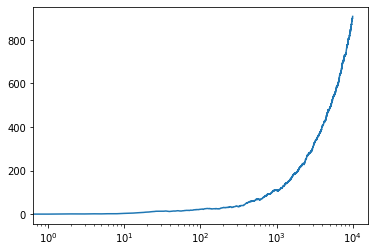

In [201]:
testbed(Optimal_LP)

In [260]:
numOfUsers = 2
numOfArticles = 5
dim = 2
T = 10000
myEnvironment = LinearEnvironment(dim=dim, numOfUsers=numOfUsers, numOfArticles=numOfArticles)
neighbors, context = myEnvironment.reveal()

mean = [[random.random() for j in range(numOfArticles)] for user in range(numOfUsers)]
gap = [[np.max(mean[user]) - m for m in mean[user]] for user in range(numOfUsers)]
sol = oracle_LP(gap, T, dim, context, neighbors)
constr = oracle_constr_LP(sol, gap, T, dim, context, neighbors)
value = oracle_obj_LP(sol.flatten(),gap)
print(f"gap = {gap}\n")
print(f"neighbors = {neighbors}\n")
print(f"sol = {sol}\n")
#print(f"constr = {constr}\n")
print(f"value = {value}\n")
print("Lattimore\n")
for user in range(numOfUsers):
    sol = oracle(gap[user], T, dim, context)
    constr = oracle_constr(sol, gap[user], T, dim, context)
    value = oracle_obj(sol,gap[user])
    print(f"sol = {sol}\n")
    #print(f"constr = {constr}\n")
    print(f"value = {value}\n")

gap = [[0.0, 0.40474549876368016, 0.43013777310706547, 0.16053042930739891, 0.015897841911241106], [0.0, 0.41514607063835407, 0.6587836379603837, 0.1957946244092681, 0.01669059518006688]]

neighbors = [[0, 1], [1]]

sol = [[5598.77647774    0.            0.          122.13841588 4279.08510639]
 [6191.25627065    0.            0.            0.         3808.74372935]]

value = 151.2053506133165

Lattimore

sol = [5680.37491465    0.            0.          130.47837485 4189.14671051]

value = 87.54414167592785

sol = [9.97631131e+03 5.40085957e-08 1.22246350e-06 2.36886849e+01
 6.15826277e-12]

value = 4.638117986018438



In [236]:
numOfArticles = 5
dim = 2
T = 10000
context = []
for j in range(numOfArticles):
    context.append(np.array([random.random() for k in range(dim)]))
mean = [random.random() for j in range(numOfArticles)]
gap = [np.max(mean) - m for m in mean]
sol = oracle(gap, T, dim, context)
constr = oracle_constr(sol, gap, T, dim, context)
value = oracle_obj(sol,gap)
print(f"gap = {gap}\n")
print(f"sol = {sol}\n")
print(f"constr = {constr}\n")
print(f"value = {value}\n")

gap = [0.0, 0.2278274298623254, 0.39100994039928316, 0.23149039679159888, 0.1580301193094138]

sol = [8948.98155406    0.            0.            0.         1051.01844594]

constr = [4.05571167e+04 1.37733179e-03 5.79023265e-03 2.01064479e-03
 8.26324686e-15]

value = 166.0925704083321



### modify x_0 to be logT or T
### increase warm up phase to be logT
### add multiple/periodic LP checks
### regret calculate based on the expected gap

In [229]:
gap = [0, 0.5, 0.3, 0, .8]
gap_filter_index = [(i,g) for i,g in enumerate(gap) if g>0]
np.min(gap_filter_index,axis = 0)[1]

0.3

In [14]:
a = np.ones((5,))
a[2]

1.0

In [9]:
fun = lambda x: (x[0] - 1)**2 + (x[1] - 2.5)**2
def my_constr(x):
    return np.array([x[0] - 2 * x[1] + 10, -x[0] - 2 * x[1] + 6, -x[0] + 2 * x[1] + 10])
cons = ({'type': 'ineq', 'fun': my_constr})
bnds = ((0, None), (0, None))
res = opt.minimize(fun, (2, 0), method='SLSQP', bounds=bnds, constraints=cons)
res.x

array([0.99999999, 2.49999999])

In [68]:
a=[1,2,3]
b=[1,2,3]
np.inner(np.array(a).reshape(3,1),np.array(b).reshape(3,1))

array([[1, 2, 3],
       [2, 4, 6],
       [3, 6, 9]])

In [172]:
a = np.arange(10)
b = a.reshape(2,5)
print(a.shape)
print(b)
b[0][0]=1
print(b)
print(a)
a[0] = 2
print(a)
print(b)

(10,)
[[0 1 2 3 4]
 [5 6 7 8 9]]
[[1 1 2 3 4]
 [5 6 7 8 9]]
[1 1 2 3 4 5 6 7 8 9]
[2 1 2 3 4 5 6 7 8 9]
[[2 1 2 3 4]
 [5 6 7 8 9]]


In [175]:
mu = [[] for i in range(5)]
mu[0] = [0 for i in range(5)]
mu[1] = [1 for i in range(5)]
mu[0] = [2 for i in range(5)]
mu

[[2, 2, 2, 2, 2], [1, 1, 1, 1, 1], [], [], []]

In [182]:
confidence = [[random.random() for i in range(5)] for j in range(5)]
print(confidence)
np.max(confidence, axis=1)

[[0.40204850935007264, 0.04778061573678938, 0.5887568737356333, 0.3442413902067991, 0.09295688335971375], [0.7087977650533256, 0.9578188636881513, 0.47132113015014476, 0.32166401271584155, 0.05665219734414706], [0.08531710840080375, 0.6677651274580647, 0.8002726379622227, 0.9509235428046836, 0.3468975388244384], [0.8808357277785608, 0.07498054018440214, 0.42333513194765215, 0.7982724137493844, 0.02788303246870405], [0.12280071457455222, 0.8065228990020264, 0.5647204203410868, 0.03422784113411381, 0.635677222317901]]


array([0.58875687, 0.95781886, 0.95092354, 0.88083573, 0.8065229 ])

In [186]:
mu = [[random.random() for i in range(5)] for j in range(5)]
mu_prev = [[random.random() for i in range(5)] for j in range(5)]
[[abs(mean - mean_prev) for mean, mean_prev in zip(mu[user],mu_prev[user])] for user in range(5)]

[[0.2426978792755886,
  0.43487251790466364,
  0.1196395593229006,
  0.18051008656268985,
  0.4623439192921842],
 [0.5200836150133619,
  0.3523671889034039,
  0.3535525730774157,
  0.4323082252420105,
  0.23820733581135634],
 [0.478000727337773,
  0.2784046103282465,
  0.12498195329830675,
  0.1674436918233807,
  0.3230823249956811],
 [0.40117844954747117,
  0.13355218197718666,
  0.9421643852845285,
  0.8639733464837205,
  0.6822805407620661],
 [0.6784347866277555,
  0.0074071880570834026,
  0.07709277171033968,
  0.597740508428315,
  0.02291942488661225]]

In [189]:
gap = [[i+j*5 for i in range(5)] for j in range(5)]
np.array(gap).flatten().shape

(25,)

In [195]:
res_list = [[i+j*5 for i in range(5)] for j in range(5)]
res = np.array(res_list)
np.sum(res[1])
res[0] = res[0]/np.sum(res[0])*100
res

array([[ 0, 10, 20, 30, 40],
       [ 5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14],
       [15, 16, 17, 18, 19],
       [20, 21, 22, 23, 24]])